In [1]:

import sys
sys.path.append('..')
from src.evo_eq_model import *

In [2]:
8e-4*2/3 /52

1.0256410256410258e-05

In [3]:
import random
import numpy.random as rnd
import networkx as nx
from anytree import Node
from tqdm import tqdm
import numpy as np
import os
import sys


if(sys.version_info[1]<= 7):
    import pickle5 as pickle
else:
    import pickle
    
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
fmt = lambda x, pos: '{:.3f}'.format(x)
from numba import jit

#matplotlib.use('TkAgg')
from matplotlib.lines import Line2D
plt.rc('mathtext', default='regular')

sns.set(context='poster')
sns.set_style("white")
plt.rc('lines', linewidth=3.0)
plt.rcParams['xtick.labelsize']=30
plt.rcParams['ytick.labelsize']=30
plt.rcParams['axes.labelsize']=35
plt.rcParams['legend.fontsize']= 25
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['image.cmap']='coolwarm'
plt.rcParams['axes.titlesize'] = 40
plt.rcParams['figure.titlesize'] = 40

In [4]:
def model(X, t, R0, kappa):
        x = X[0]
        y = X[1]
        z = X[2]
        dxdt = - R0/(1+kappa * y) *x * y
        dydt =  R0/(1+kappa* y) * x * y - y
        dzdt = y
        return [dxdt, dydt, dzdt]


In [5]:
import pandas as pd
import scipy.interpolate as spi



In [6]:
@jit(nopython=True)    
def find_t_intersection(f,g, t):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return t[idx[0]]
    else:
        return np.inf

@jit(nopython=True)    
def find_ind_intersection(f,g):
    #print(np.sign(f - g))
    idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
    #print(idx)
    if len(idx)>0:
        return idx[0]
    else:
        return np.inf

In [7]:
from matplotlib.ticker import FuncFormatter

fmt = lambda x, pos: '{:.1f}'.format(x)


In [8]:
nb_name = os.path.basename(globals()['__vsc_ipynb_file__'])
nb_name= nb_name[:nb_name.find('.ipynb')]

obsidian_vault_folder = os.path.expanduser("~")+'/Dropbox/Work_main/Obsidian/Project_tree/Project_Tree/'
figures_folder = obsidian_vault_folder + '/figures/'+nb_name+'/'
os.makedirs(figures_folder,exist_ok=True)

In [9]:
import cProfile

In [10]:
rnd.seed(101)
random.seed(101)

In [11]:
N = 1e7
R0=beta=3
mu= 1e-4
p_alpha = .1
kappa=0
xi = 50


In [12]:
mu

0.0001

In [13]:
home = os.path.expanduser("~")
project_path =  os.path.relpath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

sys.path.insert(1, project_path)
 output_folder= project_path+'/outputs/'

In [14]:
%load_ext autoreload

In [15]:
%autoreload
M_controlled = eqModel(N=N, infection_rate=beta, kappa= 1e3, recovery_rate=1, mutation_rate = mu, p_alpha= p_alpha,xi = xi, initial_infected=10,dt=None, figures_folder= figures_folder)
M_controlled.run_to_extinction()#(ignore_running= True,max_iter = 6000)
print('done')

  3%|▎         | 12174/381890 [00:20<10:09, 606.81it/s]

done


In [ ]:
M_controlled.ilast


12174

In [17]:
# delta_i = 1000
# for i in tqdm(range(M_controlled.ilast,M_controlled.ilast+delta_i)):
#     M_controlled.step()
#     if i%10 == 0:
#         M_controlled.snapshot(i*M_controlled.dt)
# M_controlled.ilast += delta_i

In [18]:

print(f'{mu:.1e}')

1.0e-04


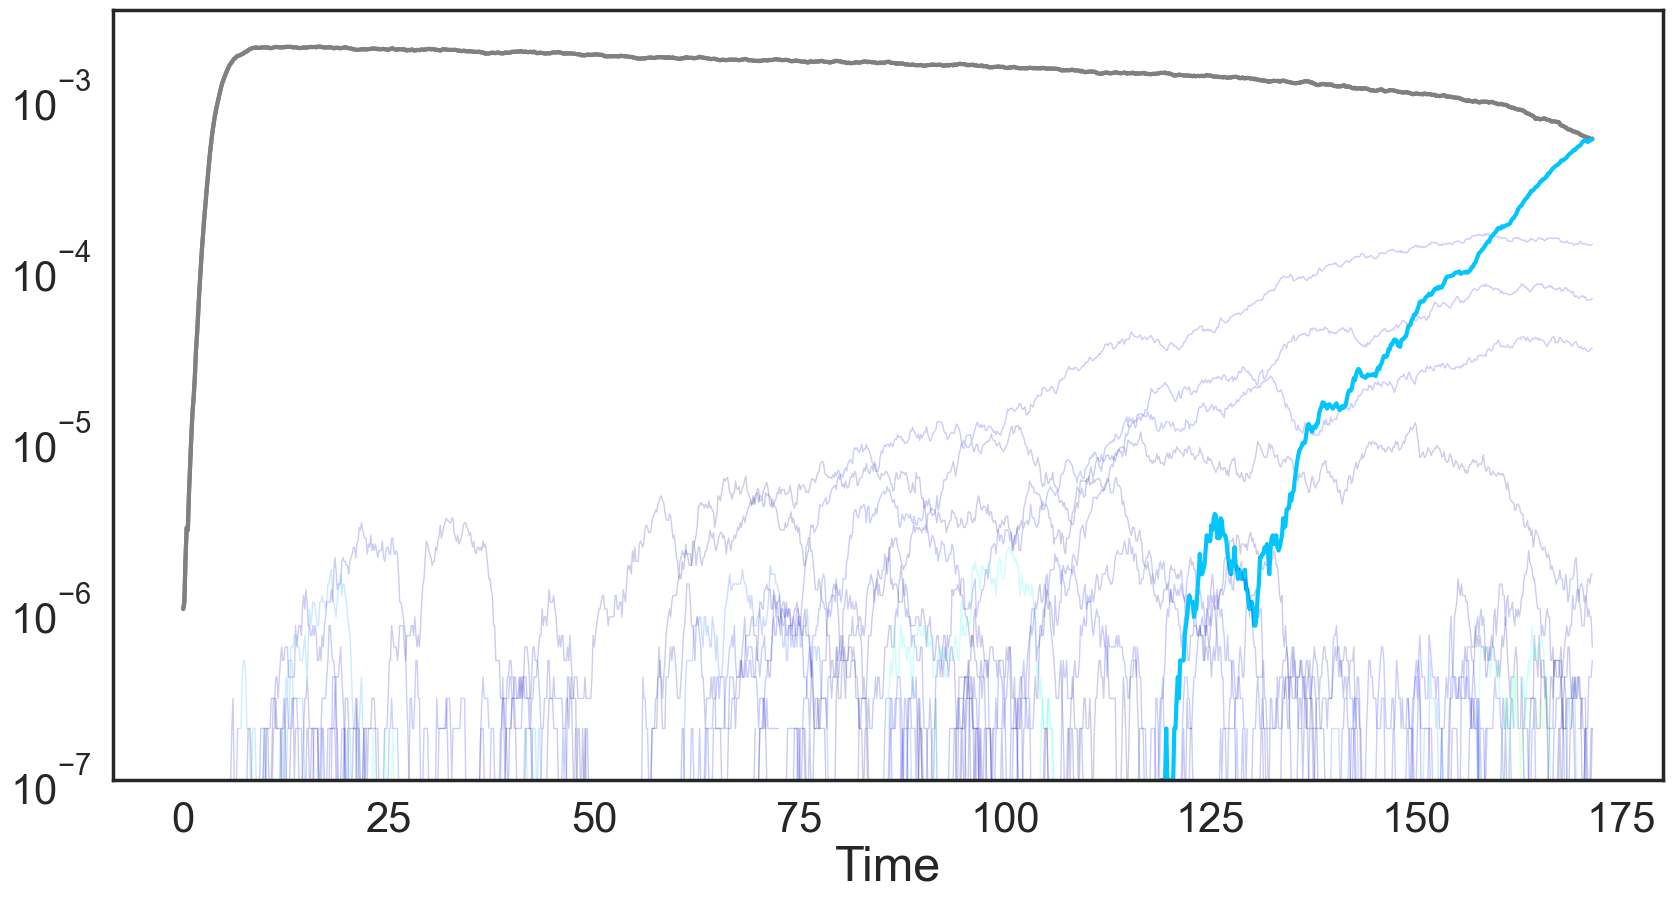

In [ ]:

self = M_controlled

ds = np.arange(0,20 + np.round(np.log(mu*N)/p_alpha))
color_ds= dict(zip(ds,plt.cm.jet(np.linspace(0,1,len(ds)))))

fig,ax =plt.subplots(1,1,figsize=(20,10),sharex=True)
ax = [ax]
plt.subplots_adjust(hspace=.1,wspace=.3)
y0p = (R0-1-np.log(R0))/R0

xinf = self.find_x_inf(R0,kappa)
T = self.calc_T(R0,kappa,N)
zinf = 1-xinf
ts_det = np.linspace(0,T,1000)
x,y,z= odeint(model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T


#get the three strains with the highest infected size
big_strains = sorted(self.strain_set, key=lambda x: x.recovered_size, reverse=True)[:5]
big_names=  [strain.name for strain in big_strains]

if True:
    ts_root= np.array(self.root_strain.times)
    I_root = np.array(self.root_strain.infected_history)
    S_root = np.array(self.root_strain.susceptible_history)
    R_root = np.array(self.root_strain.recovered_history)
    xparent = S_root/N
    zparent = R_root/N
    yparent = I_root/N
    t_peak = ts_root[np.argmax(I_root)]
    legend_ds = {}

for strain in self.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:
        
        # #ax[1].axhline(s_inf,color=color,ls='--')
        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak

            # ax[0].axvline(ts_i[np.argmin(np.abs(ts_i-t_peak))],color=color,ls='--')
        
        # ax[0].axhline(chi_0,color=color,ls='--')
        # ax[0].plot(ts_i, chi_0*np.exp(s_inf*(ts_i-t_i0)),color=color,ls=':')
        alpha= 1
        lw= 3
        # #ax[1].plot(ts_root, R0/(1+ kappa*yparent)*(1-c)*zparent,color=color, alpha= alpha, lw = lw, linestyle=':')
        #ax[1].plot(ts_root, (1-c)*zparent,color=color, alpha= alpha, lw = lw, linestyle='--')
        #ax[1].plot(ts_root, (1-c)*zparent/(1-zparent),color=color, alpha= alpha, lw = lw, linestyle='-.')
        # #ax[1].plot(ts)

    else: 
        alpha = .2
        lw= 1
    if strain.name ==0:
        ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    #ax[1].plot(ts_i,s_i ,color=color, alpha= alpha, lw = lw)    


for a in ax:
    a.set_xlabel('Time')
    
# ax[0].set_title('$y(t)$',pad=20)
# ax[0].set_ylabel('Infected fraction')
ax[0].set_yscale('log')
# ax[0].set_ylim((1/N,1))

#ax[1].set_title(r'$s(d,t) = \left(1-c(d)\right) R_0 (y) z(t) $',pad=20)
#ax[1].set_ylabel('Selection coefficient trajectory')

approx_handles = [mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='--'), mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='-.')]
approx_labels = [r'$\left(1-c(d)\right) z(t)$',r'$\left(1-c(d)\right) \frac{z(t)}{1-z(t)}$']

#ax[1].legend(handles=approx_handles,labels=approx_labels,loc='best',frameon=False)
ax[0].set_ylim(bottom=1/N)
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = ds*p_alpha
# norm = mpl.colors.BoundaryNorm(ds*p_alpha, cmap.N)
# ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
# fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                # cax=ax2, orientation='vertical', label=r'$d/\langle d \rangle$', ticks=bounds[::14], boundaries=bounds[::14],format=FuncFormatter(fmt))#, format='%1f')
# plt.savefig(output_folder+'infection_trajectories.svg',bbox_inches='tight')

In [20]:
500/52

9.615384615384615

In [21]:
def plot_strain(strain, ax_n, ax_sel, color_ds, xi, R0, xinf, t_peak, N):
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        return 0
    d_pc = strain.distance_to_parent
    c= np.exp(-d_pc/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    ts_i = np.array(strain.times)
    
    
    if strain.root_intersection_time<np.inf or strain.name==0:
        
        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak

        alpha= 1
        lw= 3

    else: 
        alpha = .2
        lw= 1
    if strain.name ==0:
        ax_n.plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax_sel.plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax_sel.plot(ts_i,s_i ,color=color, alpha= alpha, lw = lw)

In [22]:
mu_uncontrolled=  ((-1 + R0)*R0*M_controlled.mutation_rate)/(M_controlled.kappa*(-1 + R0 - np.log(R0)))
print(mu_uncontrolled)

6.656403148800867e-07


In [23]:
M_uncontrolled = eqModel(N=N, infection_rate=beta, kappa= 0, recovery_rate=1, mutation_rate = 100*mu_uncontrolled, p_alpha= p_alpha,xi = xi, initial_infected=10,dt=None, figures_folder= figures_folder)
M_uncontrolled.run_to_extinction()
print('done')

 65%|██████▌   | 2168/3321 [01:11<00:37, 30.52it/s] 

done


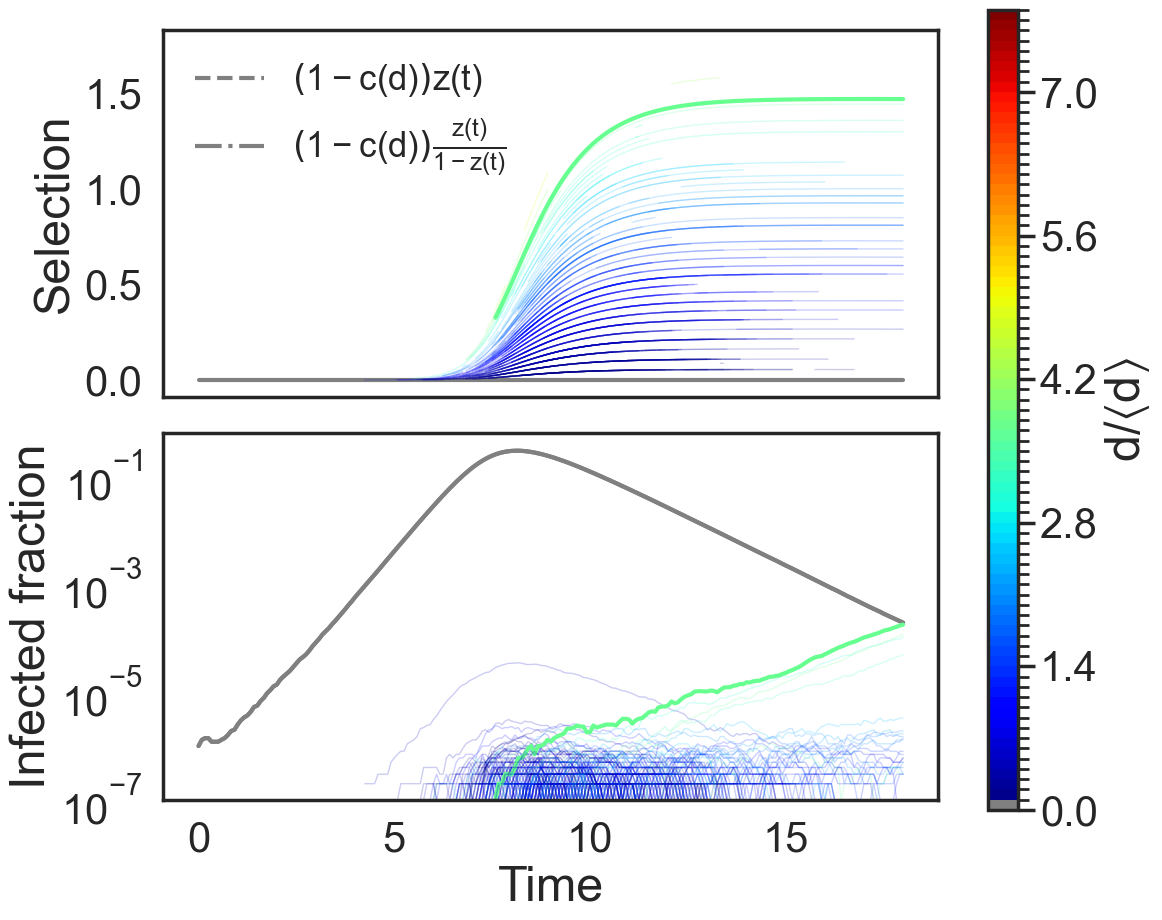

In [24]:

self = M_uncontrolled

dmax_controlled = np.max([strain.distance_to_parent for strain in M_controlled.strain_set])
dmax_uncontrolled = np.max([strain.distance_to_parent for strain in M_uncontrolled.strain_set])

ds = np.arange(0,np.max((dmax_controlled,dmax_uncontrolled))+1)
color_ds= dict(zip(ds,plt.cm.jet(np.linspace(0,1,len(ds)))))

fig,ax =plt.subplots(2,1,figsize=(10,10),sharex=True)
ax = ax[::-1]
plt.subplots_adjust(hspace=.1,wspace=.3)
y0p = (R0-1-np.log(R0))/R0

xinf = self.find_x_inf(R0,kappa)
T = self.calc_T(R0,kappa,N)
zinf = 1-xinf
ts_det = np.linspace(0,T,1000)
x,y,z= odeint(model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T


#get the three strains with the highest infected size
big_strains = sorted(self.strain_set, key=lambda x: x.recovered_size, reverse=True)[:5]
big_names=  [strain.name for strain in big_strains]

if True:
    ts_root= np.array(self.root_strain.times)
    I_root = np.array(self.root_strain.infected_history)
    S_root = np.array(self.root_strain.susceptible_history)
    R_root = np.array(self.root_strain.recovered_history)
    xparent = S_root/N
    zparent = R_root/N
    yparent = I_root/N
    t_peak = ts_root[np.argmax(I_root)]
    legend_ds = {}

for strain in self.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:
        
        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak

        alpha= 1
        lw= 3

    else: 
        alpha = .2
        lw= 1
    if strain.name ==0:
        ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax[0].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax[1].plot(ts_i,s_i ,color=color, alpha= alpha, lw = lw)    


ax[0].set_xlabel('Time')
    
ax[0].set_ylabel('Infected fraction')
ax[0].set_yscale('log')
ax[1].set_ylabel('Selection')

# approx_handles = [mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='--'), mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='-.')]
# approx_labels = [r'$\left(1-c(d)\right) z(t)$',r'$\left(1-c(d)\right) \frac{z(t)}{1-z(t)}$']

ax[1].legend(handles=approx_handles,labels=approx_labels,loc='best',frameon=False)
ax[0].set_ylim(bottom=1/N)
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = ds*p_alpha
norm = mpl.colors.BoundaryNorm(ds*p_alpha, cmap.N)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax2, orientation='vertical', label=r'$d/\langle d \rangle$', ticks=bounds[::14], boundaries=bounds[::14],format=FuncFormatter(fmt))#, format='%1f')


In [25]:
sns.set_style('ticks')

0.0
7.583333333333333
0.0
119.05877675616588


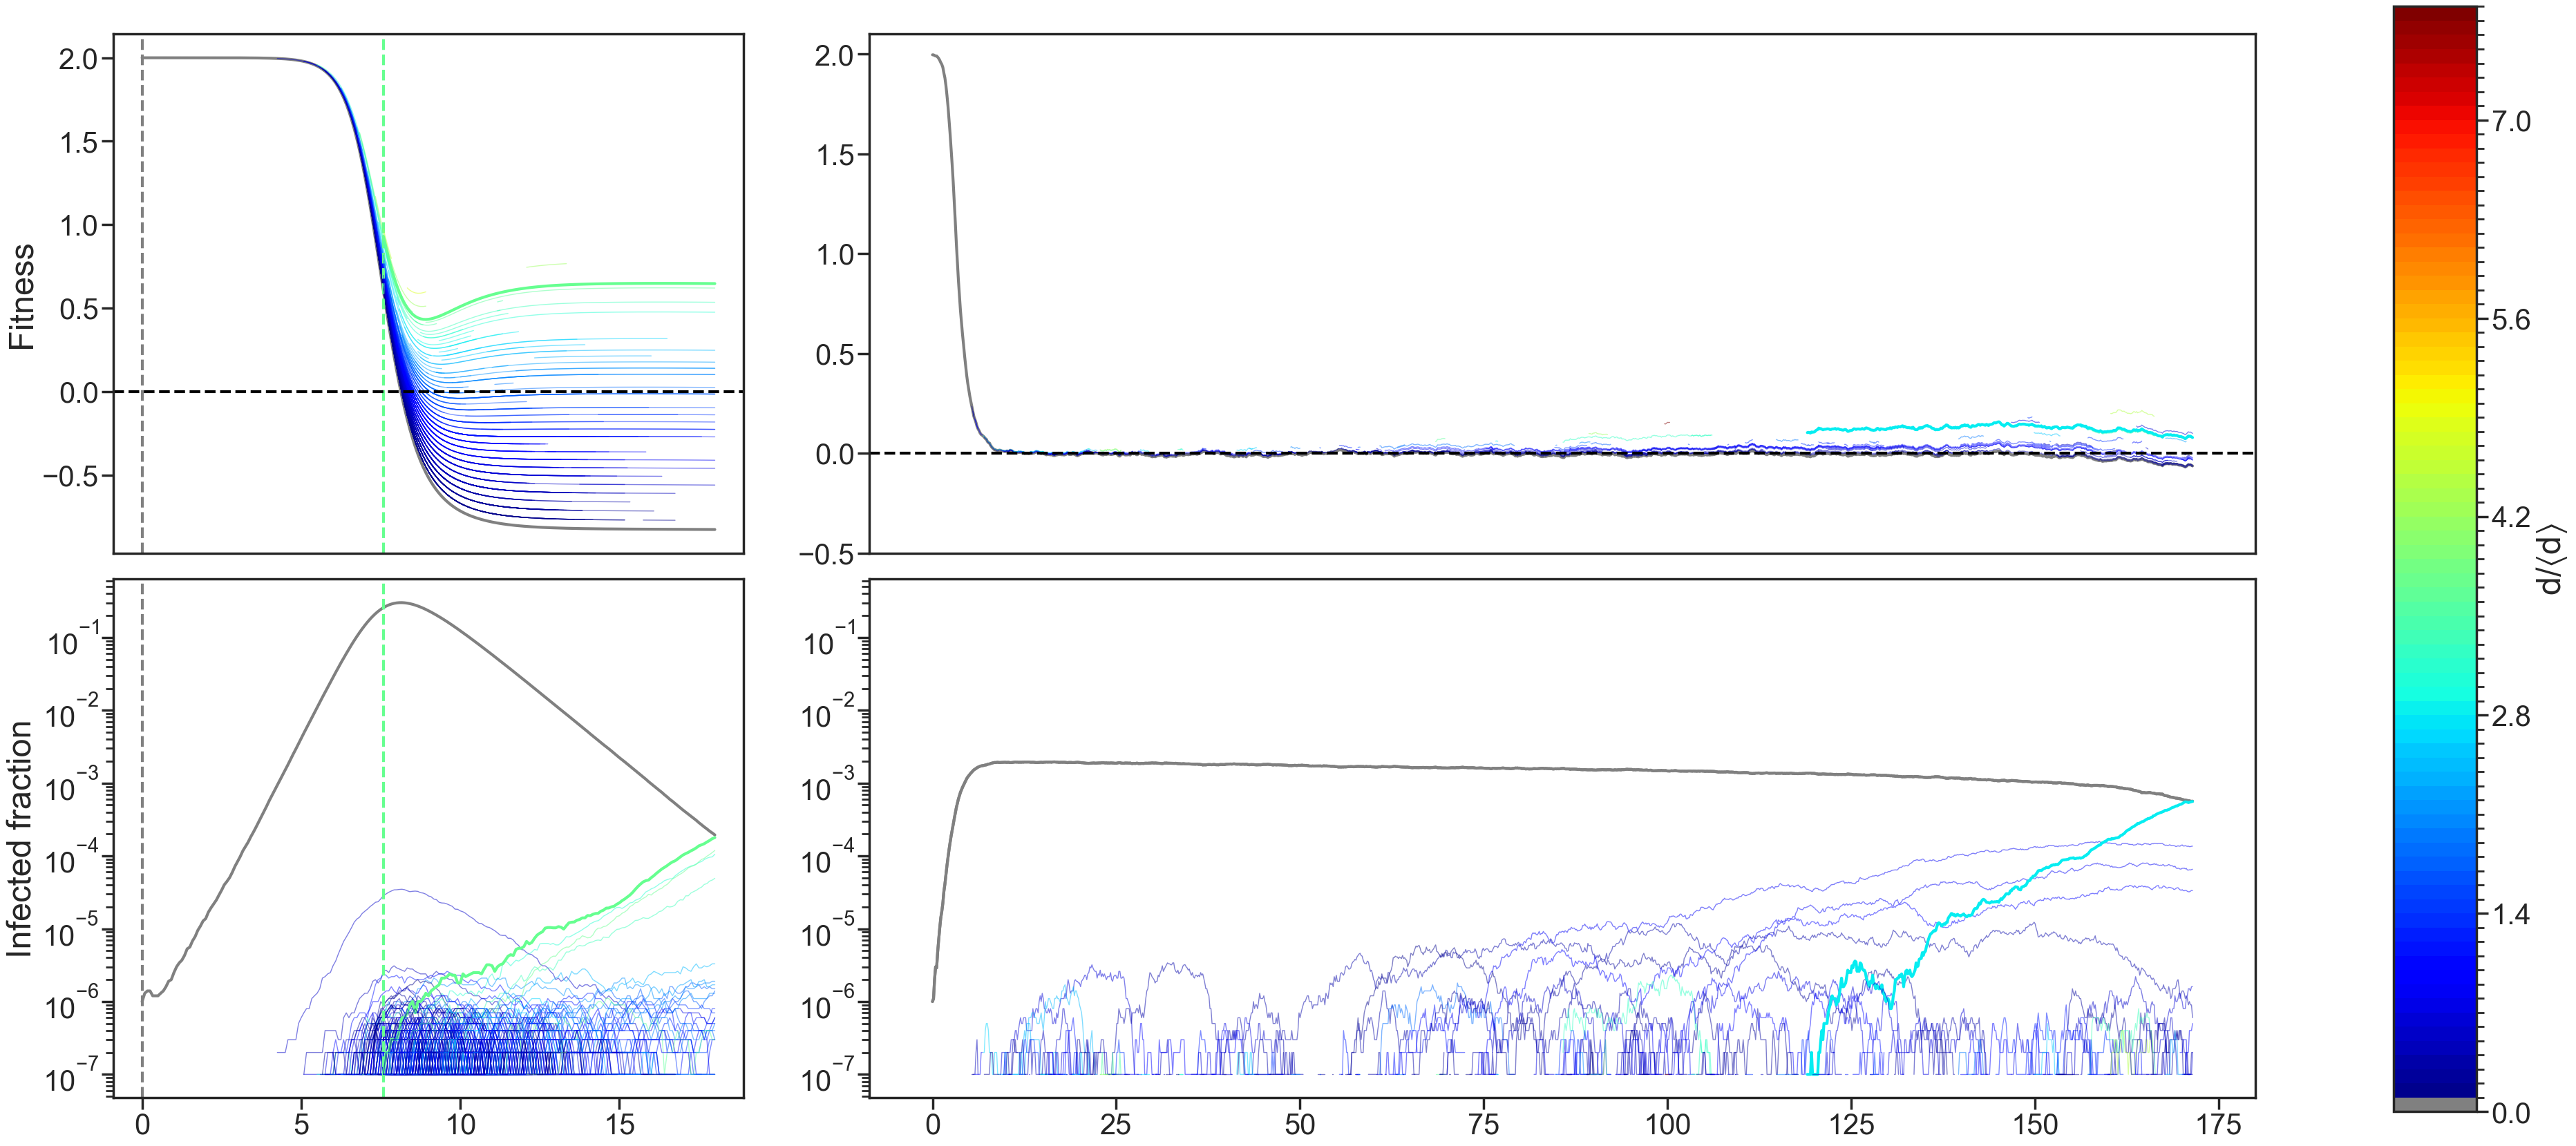

In [ ]:
figure_mosaic ="""
AACCCC
BBDDDD
"""

dmax_controlled = np.max([strain.distance_to_parent for strain in M_controlled.strain_set])
dmax_uncontrolled = np.max([strain.distance_to_parent for strain in M_uncontrolled.strain_set])

ds = np.arange(0,np.max((dmax_controlled,dmax_uncontrolled))+1)
color_ds= dict(zip(ds,plt.cm.jet(np.linspace(0,1,len(ds)))))
# ax['A'].set_yticks([])

figsize= (40,20)

fig, ax = plt.subplot_mosaic(mosaic=figure_mosaic, figsize=figsize)
plt.subplots_adjust(wspace=.5,hspace=.05)

root_strain_uncontrolled = M_uncontrolled.root_strain

for strain in M_uncontrolled.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    f_i = np.array(strain.fitness_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:

        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak
        alpha= 1
        lw= 3
        print(strain.times[0])
        ax['A'].axvline(strain.times[0],color=color,ls='--')
        ax['B'].axvline(strain.times[0],color=color,ls='--')

    else: 
        alpha = .5
        lw= 1
    if strain.name ==0:
        ax['B'].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
        ax['A'].plot(ts_i,f_i ,color=color, alpha= alpha, lw = lw)
    if strain.parent == root_strain_uncontrolled:
        ax['B'].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
        ax['A'].plot(ts_i,f_i ,color=color, alpha= alpha, lw = lw)    
ax['B'].set_yscale('log')

for strain in M_controlled.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    f_i = np.array(strain.fitness_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:

        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak
        alpha= 1
        lw= 3
        print(strain.times[0])
        

    else: 
        alpha = .5
        lw= 1
    if strain.name ==0:
        ax['D'].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax['D'].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax['C'].plot(ts_i,f_i ,color=color, alpha= alpha, lw = lw)    
ax['D'].set_yscale('log')

ax['A'].set_xticks([])
ax['C'].set_xticks([])

ax['D'].set_ylim(ax['B'].get_ylim())
ax['A'].set_ylabel('Fitness')
ax['B'].set_ylabel('Infected fraction')
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = ds*p_alpha
norm = mpl.colors.BoundaryNorm(ds*p_alpha, cmap.N)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax2, orientation='vertical', label=r'$d/\langle d \rangle$', ticks=bounds[::14], boundaries=bounds[::14],format=FuncFormatter(fmt))#, format='%1f')

ax['C'].set_ylim(bottom = ax['A'].get_ylim()[0]/8)
#set yticks of ax['C'] to be the same as ax['A']
yticks = ax['A'].get_yticks()
ax['C'].set_yticks(yticks[1:-1])
for a in ['A','C']:
    ax[a].axhline(0,color='black',lw=3,ls='--')

# for a in ax.values():
#     for tick in a.xaxis.get_major_ticks():
#         tick.label.set_fontsize(40) 
#     for tick in a.yaxis.get_major_ticks():
#         tick.label.set_fontsize(40)
#         #logarithmic ticks


        


In [27]:
AAAAAA

NameError: name 'AAAAAA' is not defined

In [94]:
originations_uncontrolled = [strain.times[0] for strain in M_uncontrolled.strain_set if strain.name!=0 and strain.times]

originations_putative_establieshed = [strain.times[0] for strain in M_uncontrolled.strain_set if strain.name!=0 and strain.times and np.max(strain.infected_history)*strain.fitness_history[0]>1]

([4.25,
  5.083333333333333,
  5.083333333333333,
  5.5,
  5.583333333333333,
  5.666666666666667,
  5.75,
  5.75,
  5.75,
  5.833333333333333,
  5.916666666666667,
  5.916666666666667,
  6.0,
  6.0,
  6.083333333333333,
  6.166666666666667,
  6.166666666666667,
  6.25,
  6.25,
  6.25,
  6.333333333333333,
  6.416666666666667,
  6.416666666666667,
  6.5,
  6.5,
  6.5,
  6.583333333333333,
  6.583333333333333,
  6.666666666666667,
  6.666666666666667,
  6.75,
  6.75,
  6.75,
  6.75,
  6.75,
  6.833333333333333,
  6.833333333333333,
  6.833333333333333,
  6.833333333333333,
  6.833333333333333,
  6.833333333333333,
  6.833333333333333,
  6.833333333333333,
  6.833333333333333,
  6.833333333333333,
  6.916666666666667,
  6.916666666666667,
  6.916666666666667,
  6.916666666666667,
  6.916666666666667,
  6.916666666666667,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.0,
  7.083333333333333,
  7.083333333333333,
  7.083333333333333,
  7.083333333333333,
  7.083333333333333,
  7.083333333333333,
 

In [96]:
originations_uncontrolled_x_thresh_dict = {}
x_thresh_vals = np.array([1e-7, 1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
for x_thresh in x_thresh_vals:
    originations_uncontrolled_x = [strain.times[0] for strain in M_uncontrolled.strain_set if strain.name!=0 and 
    strain.times and np.max(strain.frequency_history)>x_thresh]
    
    originations_uncontrolled_x_thresh_dict[x_thresh] = originations_uncontrolled_x


(0.0, 0.4528052805280519)
(-150594.05000000002, 3162695.05)


(-0.021560656332043612, 0.4528052805280519)

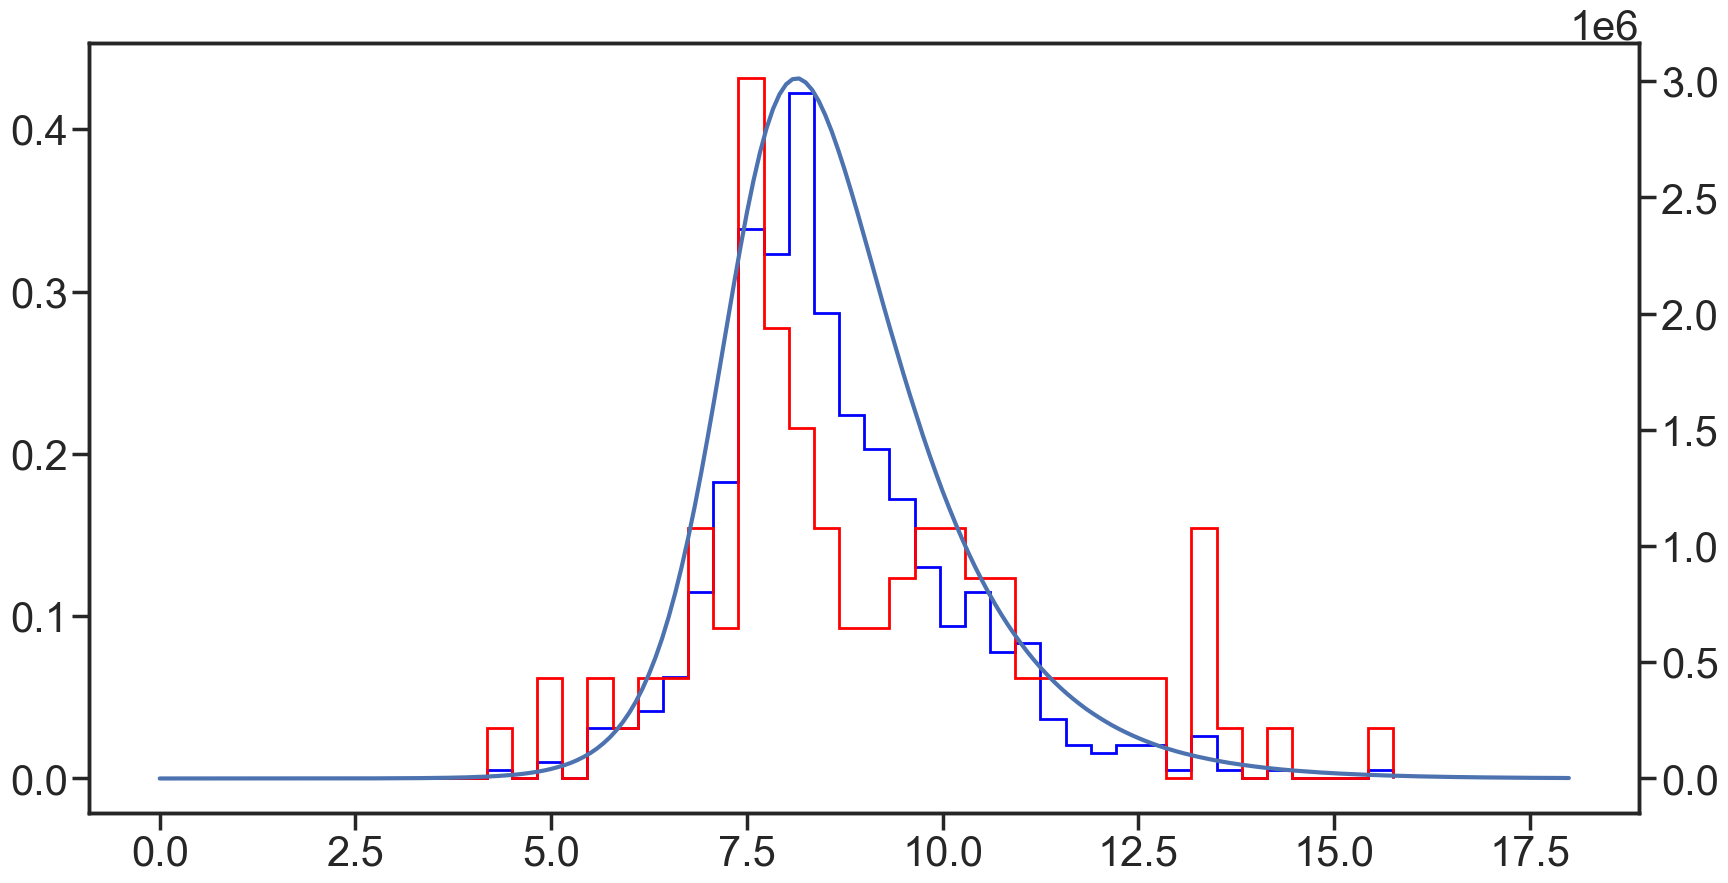

In [100]:
fig,ax = plt.subplots(1,1,figsize=(20,10))

tbins = np.linspace(0,np.max(originations_uncontrolled),50)
plt.hist(originations_uncontrolled,bins=tbins, alpha=1, color='blue',label='Uncontrolled',histtype='step',density=True,lw=2);
# for x_thresh in x_thresh_vals:

plt.hist(originations_uncontrolled_x_thresh_dict[1e-5],bins=tbins, alpha=1, label=f'Uncontrolled x>{x_thresh}',histtype='step',density=True, color='red'); 

# plt.hist(originations_putative_establieshed,bins=tbins, alpha=1, label='Controlled',histtype='step',density=True, color='green');

tax = ax.twinx()
ts_root= np.array(M_uncontrolled.root_strain.times)
I_root = np.array(M_uncontrolled.root_strain.infected_history)
tax.plot(ts_root, I_root)

#align 0 of ax and tax so that they are at the same height in the figure 
print(ax.get_ylim())
print(tax.get_ylim())
ratio = tax.get_ylim()[1]/tax.get_ylim()[0]
ax.set_ylim((ax.get_ylim()[1]/ratio,ax.get_ylim()[1]))


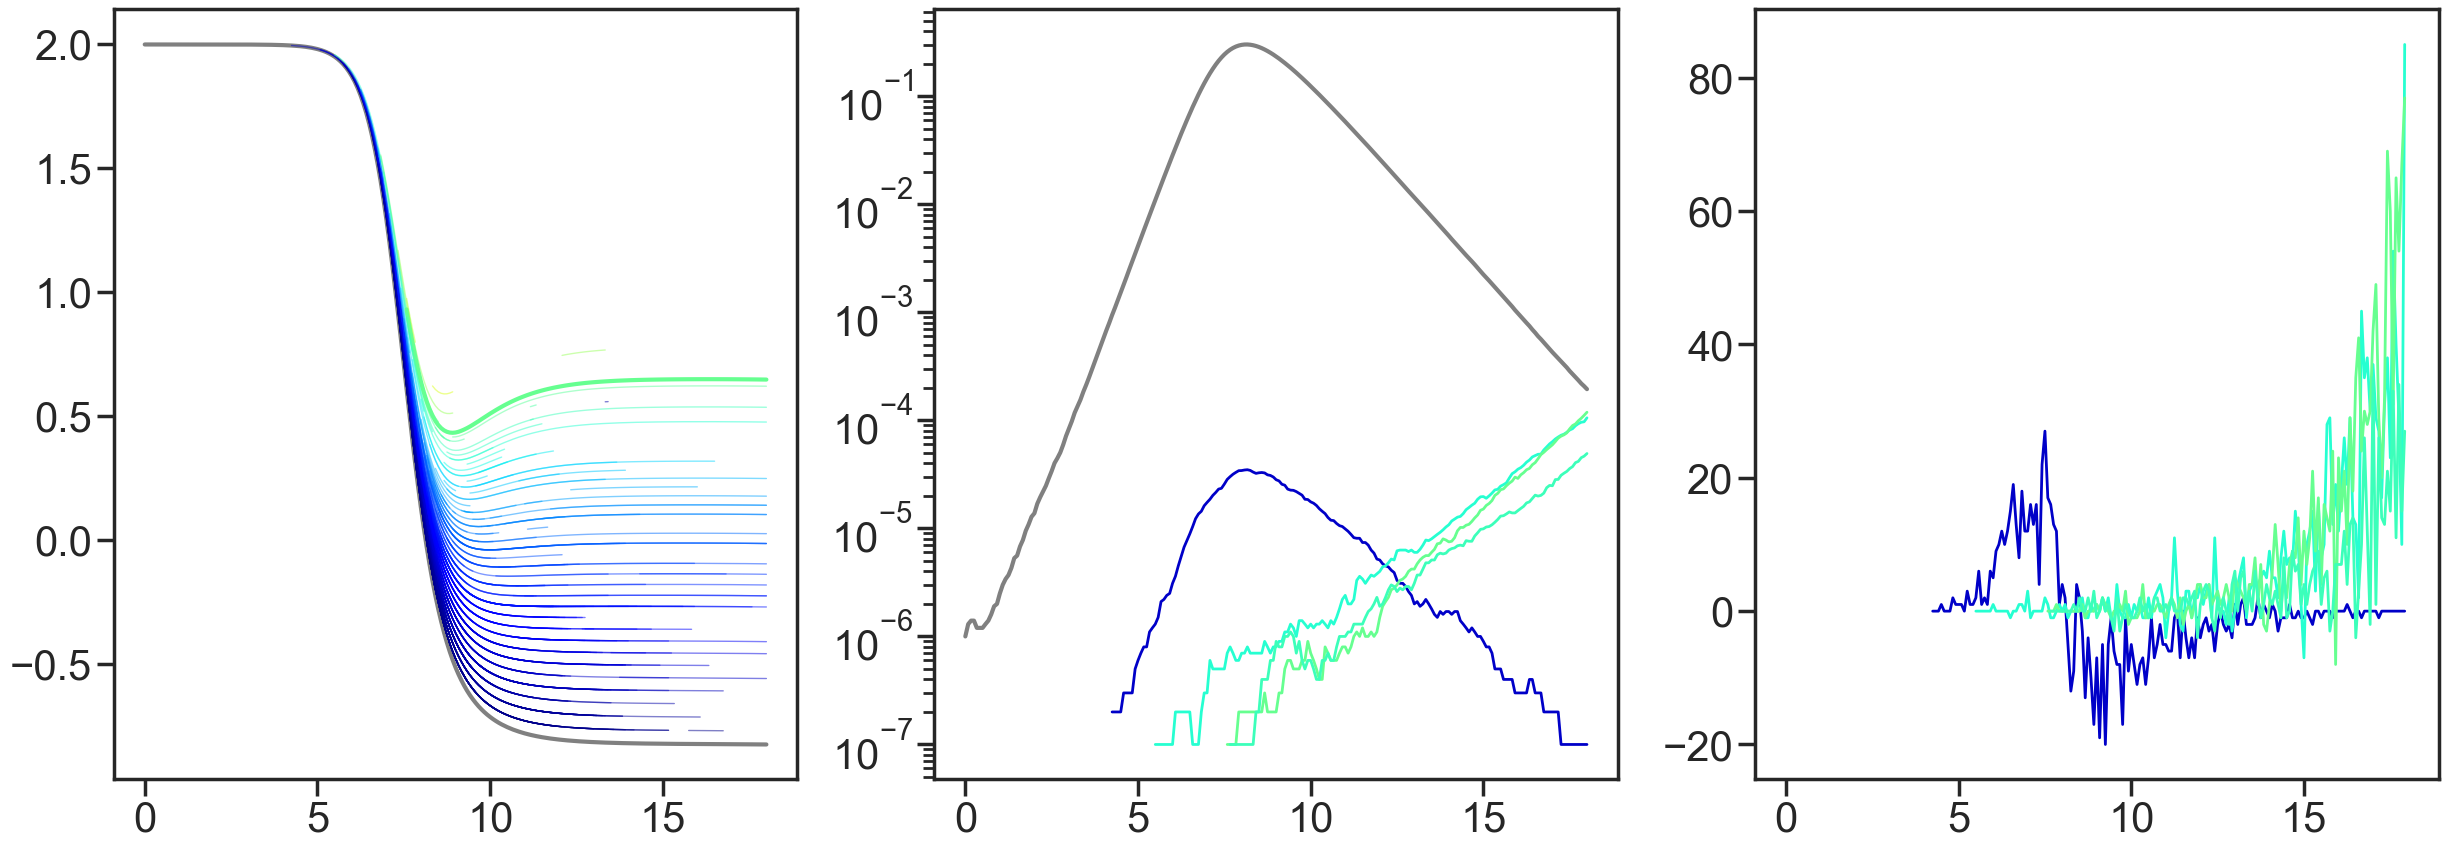

In [28]:
fig,ax = plt.subplots(1,3,figsize=(30,10),sharex=True)
for strain in M_uncontrolled.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    f_i = np.array(strain.fitness_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:

        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak
        alpha= 1
        lw= 3

    else: 
        alpha = .5
        lw= 1
    if strain.name ==0:
        ax[1].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    try:
        if np.max(np.diff(I_i))>10 and strain.name>0 and np.isinf(strain.root_intersection_time):
            ax[1].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= 1, lw = 2)
            ax[2].plot(ts_i[chi_i>0][:-1],np.diff(I_i[chi_i>0]),color=color, alpha= 1, lw = 2)
    except ValueError:
        pass
    ax[0].plot(ts_i,f_i ,color=color, alpha= alpha, lw = lw)  
ax[1].set_yscale('log')

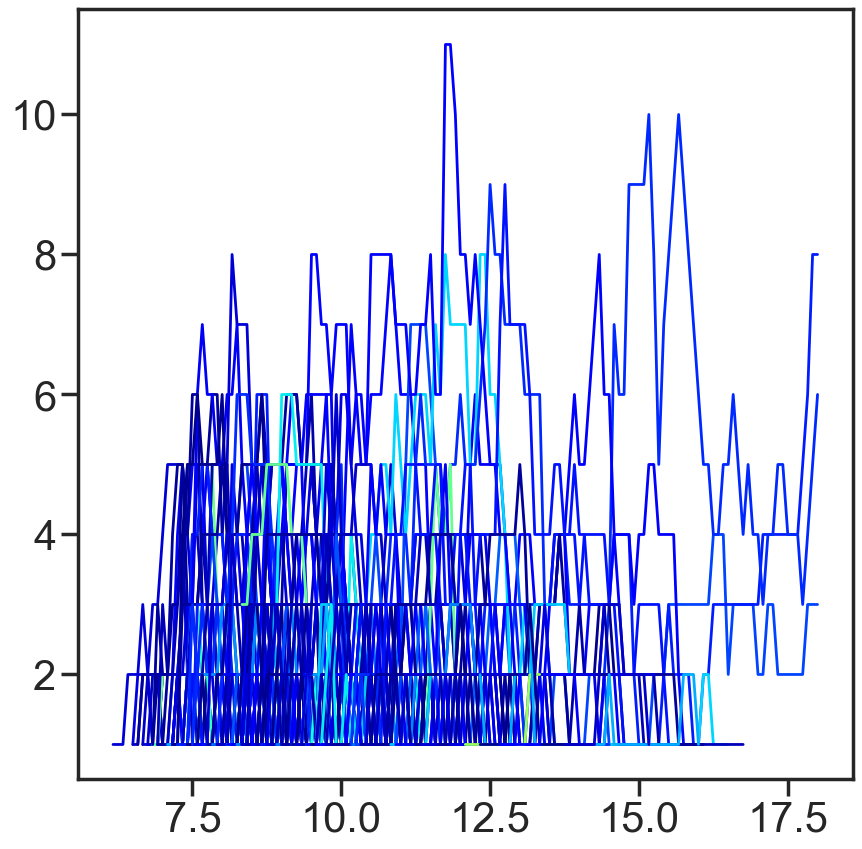

In [29]:
fig,ax = plt.subplots(1,1,figsize=(10,10),sharex=True)
for strain in M_uncontrolled.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    f_i = np.array(strain.fitness_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:

        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak
        alpha= 1
        lw= 3

    else: 
        alpha = .5
        lw= 1
    # if strain.name ==0:
        # ax[1].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    try:
        if np.max(np.diff(I_i))/np.max(I_i)>.32 and strain.name>0 and np.isinf(strain.root_intersection_time):
            # ax[1].plot(ts_i[chi_i>0],I_i[chi_i>0]/N,color=color, alpha= 1, lw = 2)
            ax.plot(ts_i[chi_i>0],I_i[chi_i>0],color=color, alpha= 1, lw = 2)
    except ValueError:
        pass
    # ax[0].plot(ts_i,f_i ,color=color, alpha= alpha, lw = lw)  
# ax.set_yscale('log')
# ax.set_ylim(-.5,.2)

In [30]:


dmax_controlled = np.max([strain.distance_to_parent for strain in M_controlled.strain_set]4
dmax_uncontrolled = np.max([strain.distance_to_parent for strain in M_uncontrolled.strain_set])

ds = np.arange(0,np.max((dmax_controlled,dmax_uncontrolled))+1)
color_ds= dict(zip(ds,plt.cm.jet(np.linspace(0,1,len(ds)))))

fig,ax =plt.subplots(1,1,figsize=(10,10),sharex=True)

plt.subplots_adjust(hspace=.1,wspace=.3)
y0p = (R0-1-np.log(R0))/R0

xinf = M_controlled.find_x_inf(R0,kappa)
T = M_controlled.calc_T(R0,kappa,N)
zinf = 1-xinf
ts_det = np.linspace(0,T,1000)
x,y,z= odeint(model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T


#get the three strains with the highest infected size
big_strains = sorted(M_controlled.strain_set, key=lambda x: x.recovered_size, reverse=True)[:5]
big_names=  [strain.name for strain in big_strains]

if True:
    ts_root= np.array(M_controlled.root_strain.times)
    I_root = np.array(M_controlled.root_strain.infected_history)
    S_root = np.array(M_controlled.root_strain.susceptible_history)
    R_root = np.array(M_controlled.root_strain.recovered_history)
    xparent = S_root/N
    zparent = R_root/N
    yparent = I_root/N
    t_peak = ts_root[np.argmax(I_root)]
    legend_ds = {}

for strain in M_controlled.strain_set:
    if strain.name==0:
        color='grey'
    else:
        color = color_ds[strain.distance_to_parent]

    I_i = np.array(strain.infected_history)
    if len(I_i)==0:
        continue

    c= np.exp(-strain.distance_to_parent/xi)
    s_inf = R0*(1-xinf)*(1-c)
    

    chi_i = np.array(strain.frequency_history)
    s_i = np.array(strain.selection_history)
    ts_i = np.array(strain.times)
    d_pc = strain.distance_to_parent
    
    if strain.root_intersection_time<np.inf or strain.name==0:
        
        t_i0 = ts_i[0]
        chi_0 = chi_i[0]
        if t_i0<t_peak:
            t_i0 = t_peak

        alpha= 1
        lw= 3

    else: 
        alpha = .2
        lw= 1
    if strain.name ==0:
        ax.plot(ts_i[chi_i>0],chi_i[chi_i>0]/N,color=color, alpha= alpha, lw = lw)
    ax.plot(ts_i[chi_i>0],chi_i[chi_i>0],color=color, alpha= alpha, lw = lw)
    


ax.set_xlabel('Time, [recovery periods]')
    
ax.set_ylabel('Frequency')
# ax.set_yscale('log')


# approx_handles = [mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='--'), mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='-.')]
# approx_labels = [r'$\left(1-c(d)\right) z(t)$',r'$\left(1-c(d)\right) \frac{z(t)}{1-z(t)}$']


ax.set_ylim(bottom=1/N)
cmap = plt.cm.jet  # define the colormap
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
bounds = ds*p_alpha
norm = mpl.colors.BoundaryNorm(ds*p_alpha, cmap.N)
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=ax2, orientation='vertical', label=r'$d/\langle d \rangle$', ticks=bounds[::14], boundaries=bounds[::14],format=FuncFormatter(fmt))#, format='%1f')

frequency_examples = os.getcwd()+'/frequency_examples/'
os.makedirs(frequency_examples,exist_ok=True)
figname = lambda i: frequency_examples+f'fig_{i}.pdf'
i=0
while os.path.exists(figname(i)):
    i+=1
plt.savefig(figname(i),bbox_inches='tight')

SyntaxError: '(' was never closed (1447080459.py, line 1)

In [ ]:
M_controlled_list = []
N= 1e7
mu = 500/N

for i in range(10):
    M_controlled = eqModel(N=N, infection_rate=beta, kappa= 100, recovery_rate=1, mutation_rate = mu, p_alpha= p_alpha,xi = xi, initial_infected=10,dt=None, figures_folder= figures_folder)
    M_controlled.run_to_extinction()
    M_controlled_list.append(M_controlled)
    print(f'{i}-th done')

  0%|          | 0/44805 [00:00<?, ?it/s]

 10%|▉         | 4278/44805 [02:14<21:10, 31.90it/s]  


0-th done


  9%|▉         | 3923/44805 [01:11<12:21, 55.14it/s]  


1-th done


 10%|█         | 4703/44805 [01:51<15:51, 42.15it/s]  


2-th done


  9%|▉         | 4216/44805 [01:56<18:41, 36.19it/s]  


3-th done


 12%|█▏        | 5568/44805 [02:54<20:32, 31.84it/s]  


4-th done


  8%|▊         | 3607/44805 [01:13<14:03, 48.86it/s]  


5-th done


 10%|█         | 4691/44805 [02:08<18:21, 36.41it/s]  


6-th done


  7%|▋         | 3158/44805 [01:07<14:44, 47.07it/s]  


7-th done


 12%|█▏        | 5203/44805 [02:13<16:53, 39.07it/s]  


8-th done


 10%|▉         | 4454/44805 [01:43<15:41, 42.85it/s]  

9-th done


In [ ]:
np.log10(N)

7.0

In [ ]:
N = 1e7
mu = 500/N
M_controlled_list_1000 = []

for i in range(10):
    M_controlled = eqModel(N=N, infection_rate=beta, kappa= 1000, recovery_rate=1, mutation_rate = mu, p_alpha= p_alpha,xi = xi, initial_infected=10,dt=None, figures_folder= figures_folder)
    M_controlled.run_to_extinction()
    M_controlled_list_1000.append(M_controlled)
    print(f'{i}-th done')

  4%|▎         | 13413/381890 [00:42<19:39, 312.40it/s] 


0-th done


  3%|▎         | 10926/381890 [00:34<19:31, 316.55it/s]


1-th done


  2%|▏         | 8118/381890 [00:27<21:14, 293.21it/s] 


2-th done


  3%|▎         | 12832/381890 [01:11<34:27, 178.53it/s]  


3-th done


  3%|▎         | 10796/381890 [00:42<24:29, 252.58it/s]  


4-th done


  4%|▍         | 14401/381890 [01:25<36:26, 168.08it/s]  


5-th done


  4%|▎         | 14093/381890 [01:35<41:31, 147.61it/s]  


6-th done


  3%|▎         | 12641/381890 [01:22<40:12, 153.09it/s]  


7-th done


  3%|▎         | 11156/381890 [00:52<29:03, 212.61it/s] 


8-th done


  4%|▍         | 15174/381890 [01:46<42:52, 142.53it/s]  

9-th done


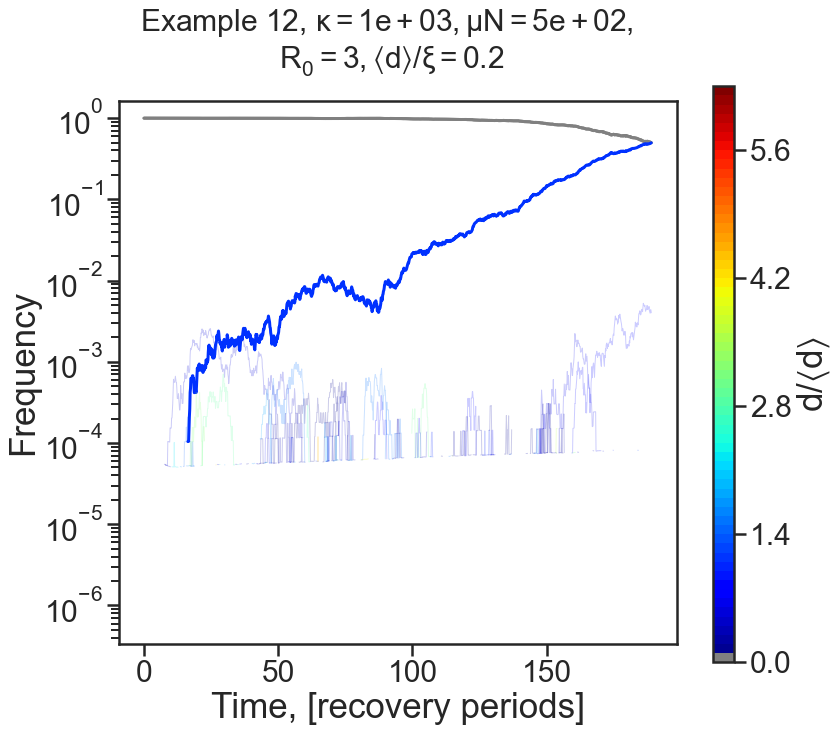

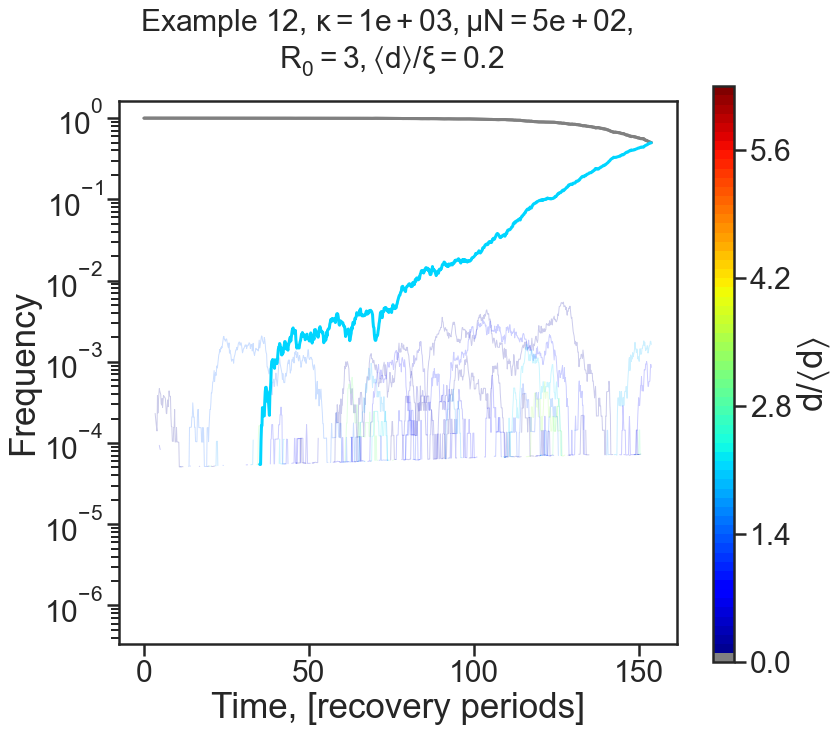

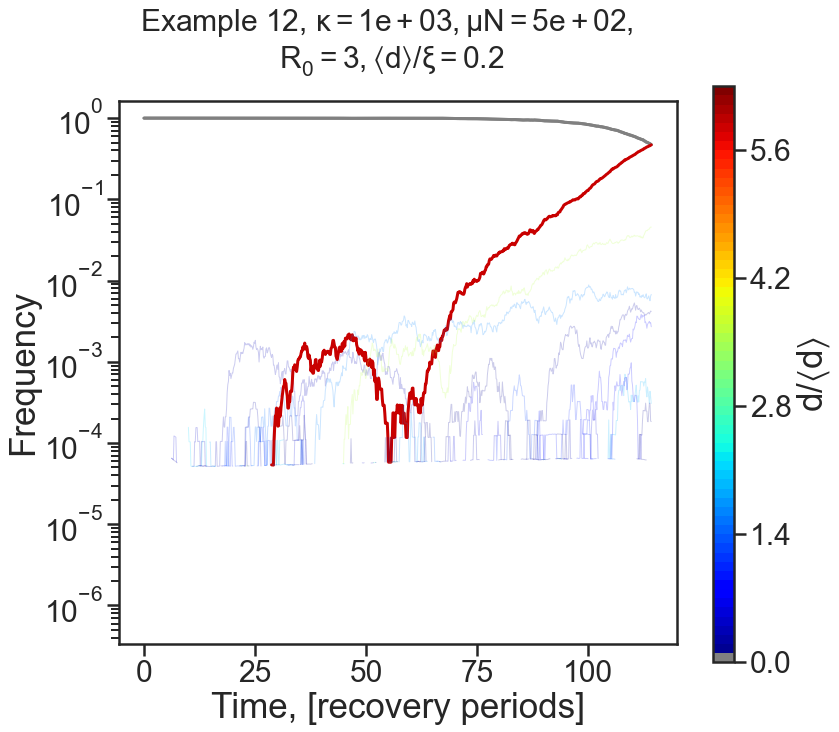

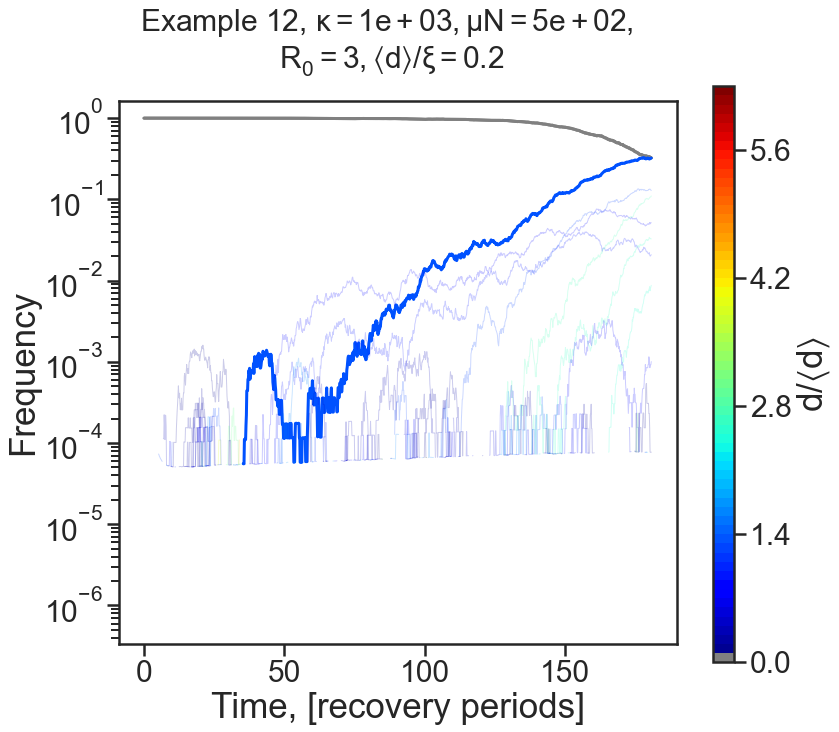

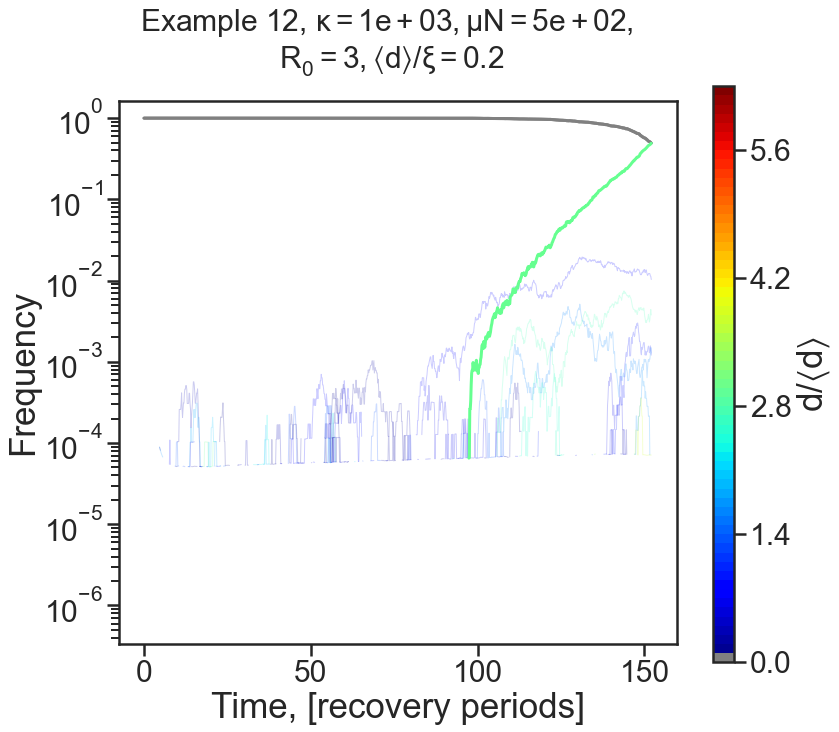

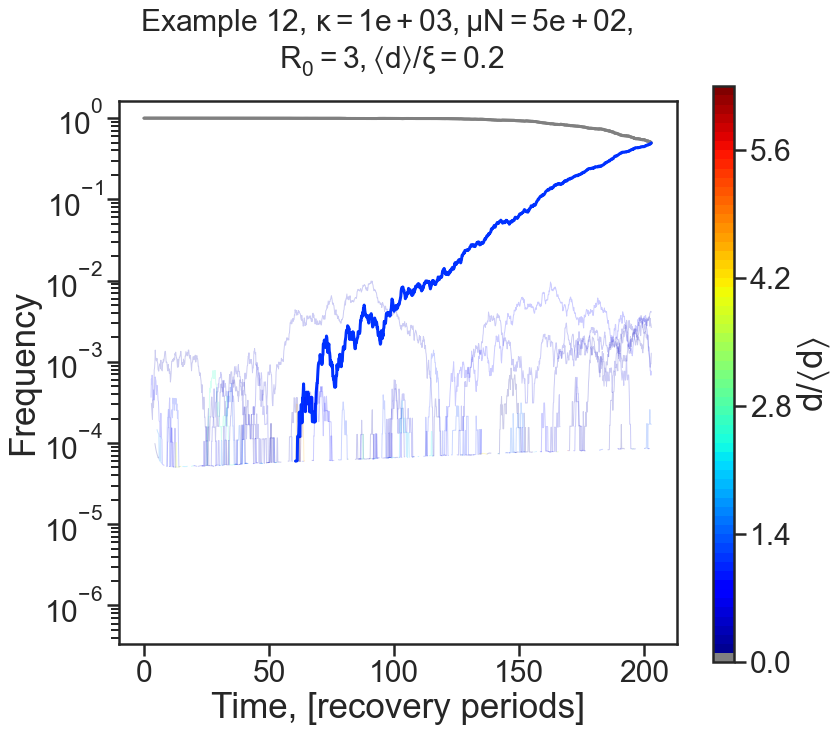

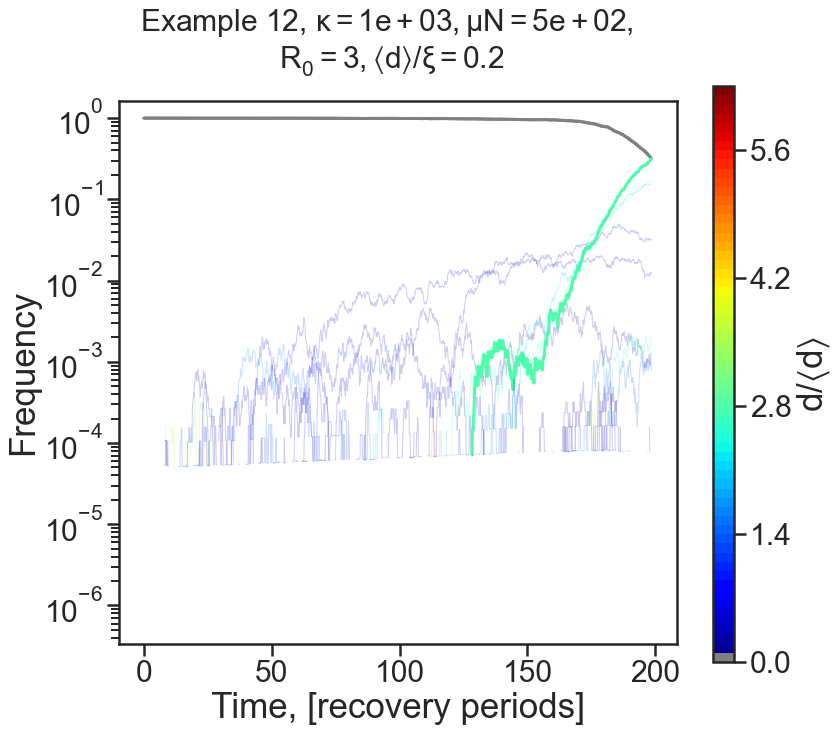

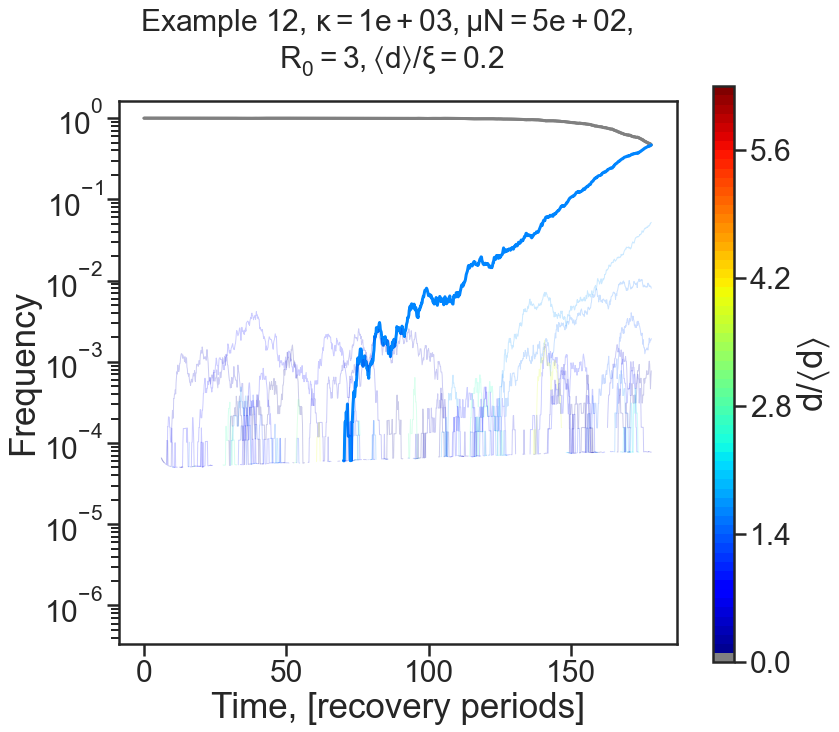

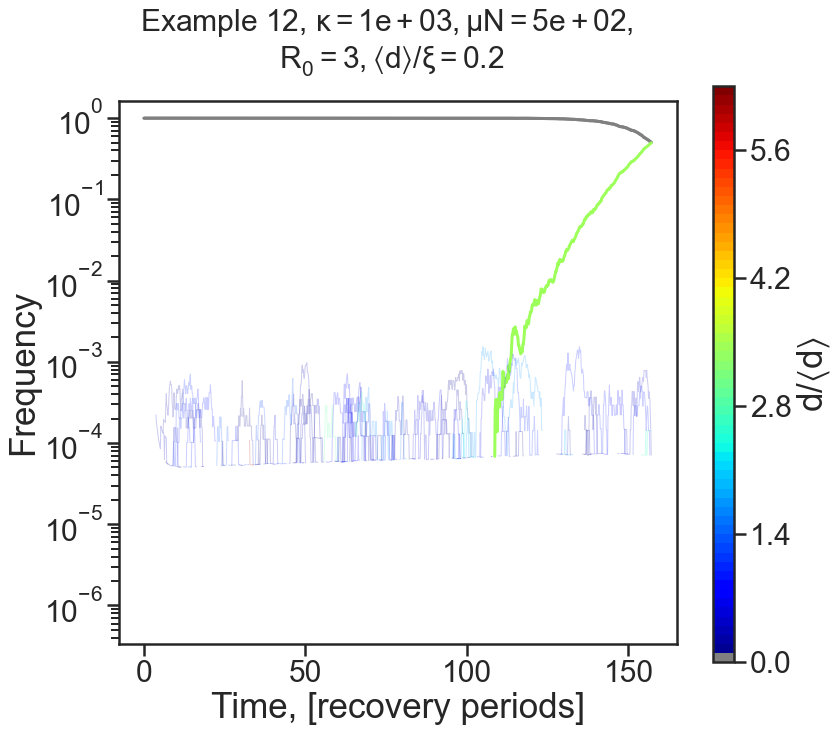

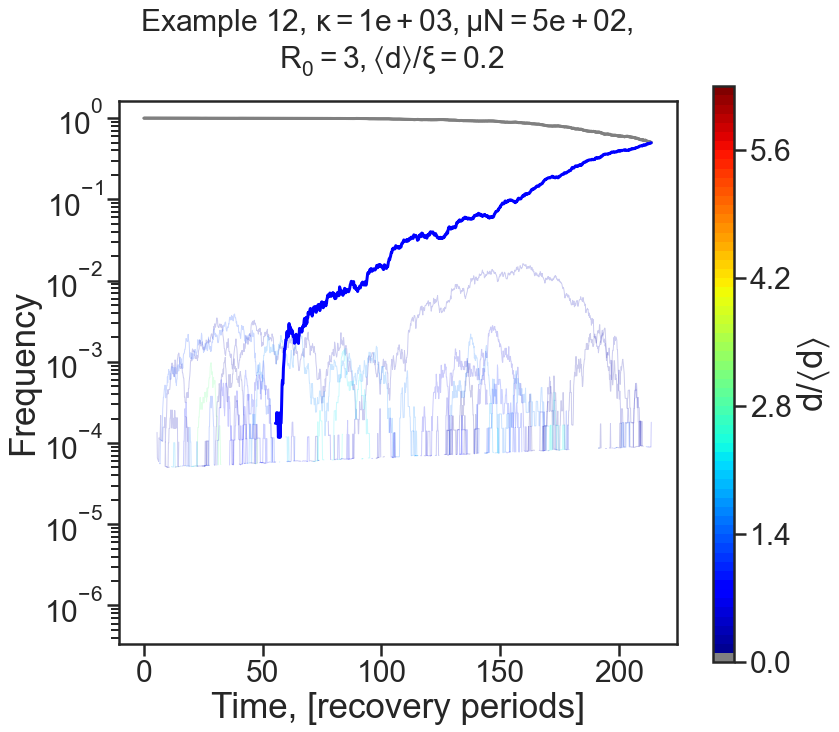

In [ ]:
for M_controlled in M_controlled_list_1000:
    N = M_controlled.N

    fig,ax =plt.subplots(1,1,figsize=(10,10),sharex=True)

    plt.subplots_adjust(hspace=.1,wspace=.3)
    y0p = (R0-1-np.log(R0))/R0

    xinf = M_controlled.find_x_inf(R0,kappa)
    T = M_controlled.calc_T(R0,kappa,N)
    zinf = 1-xinf
    ts_det = np.linspace(0,T,1000)
    x,y,z= odeint(model, np.array([1-10/N,10/N,0]), ts_det, args=(R0,kappa)).T


    #get the three strains with the highest infected size
    big_strains = sorted(M_controlled.strain_set, key=lambda x: x.recovered_size, reverse=True)[:5]
    big_names=  [strain.name for strain in big_strains]

    if True:
        ts_root= np.array(M_controlled.root_strain.times)
        I_root = np.array(M_controlled.root_strain.infected_history)
        S_root = np.array(M_controlled.root_strain.susceptible_history)
        R_root = np.array(M_controlled.root_strain.recovered_history)
        xparent = S_root/N
        zparent = R_root/N
        yparent = I_root/N
        t_peak = ts_root[np.argmax(I_root)]
        legend_ds = {}

    for strain in M_controlled.strain_set:
        if strain.name==0:
            color='grey'
        else:
            color = color_ds[strain.distance_to_parent]

        I_i = np.array(strain.infected_history)
        if len(I_i)==0:
            continue

        c= np.exp(-strain.distance_to_parent/xi)
        s_inf = R0*(1-xinf)*(1-c)
        

        chi_i = np.array(strain.frequency_history)
        s_i = np.array(strain.selection_history)
        ts_i = np.array(strain.times)
        d_pc = strain.distance_to_parent
        
        if strain.root_intersection_time<np.inf or strain.name==0:
            
            t_i0 = ts_i[0]
            chi_0 = chi_i[0]
            s_i0 = s_i[0]
            s_ilast= s_i[-1]
            if t_i0<t_peak:
                t_i0 = t_peak

            alpha= 1
            lw= 3
            # if strain.name!=0:
            #     ax.plot(ts_i[chi_i>0],chi_0/s_ilast * np.exp(s_ilast*(ts_i[chi_i>0]-t_i0)),color=color, alpha= alpha, lw = lw,linestyle=':')

        else: 
            alpha = .2
            lw= 1
        if strain.name ==0:
            ax.plot(ts_i[chi_i>0],chi_i[chi_i>0],color=color, alpha= alpha, lw = lw)
        ax.plot(ts_i[chi_i>0],chi_i[chi_i>0],color=color, alpha= alpha, lw = lw)
        


    ax.set_xlabel('Time, [recovery periods]')
        
    ax.set_ylabel('Frequency')
    # ax.set_yscale('logit')
    ax.set_yscale('log')


    # approx_handles = [mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='--'), mpl.lines.Line2D([0], [0], color='grey', lw=3, linestyle='-.')]
    # approx_labels = [r'$\left(1-c(d)\right) z(t)$',r'$\left(1-c(d)\right) \frac{z(t)}{1-z(t)}$']


    ax.set_ylim(bottom=1/(N*y0p))
    cmap = plt.cm.jet  # define the colormap
    cmaplist = [cmap(i) for i in range(cmap.N)]
    cmaplist[0] = (.5, .5, .5, 1.0)
    cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'Custom cmap', cmaplist, cmap.N)
    bounds = ds*p_alpha
    norm = mpl.colors.BoundaryNorm(ds*p_alpha, cmap.N)
    ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=ax2, orientation='vertical', label=r'$d/\langle d \rangle$', ticks=bounds[::14], boundaries=bounds[::14],format=FuncFormatter(fmt))#, format='%1f')

    frequency_examples = os.getcwd()+'/frequency_examples/'
    os.makedirs(frequency_examples,exist_ok=True)
    figname = lambda i: frequency_examples+f'fig_{i}.pdf'
    i=0
    while os.path.exists(figname(i)):
        i+=1
    
    fig.suptitle(fr'Example {i}, $\kappa = {M_controlled.kappa:.0e}, \mu N = {M_controlled.mutation_rate* M_controlled.N:.0e}$, '+'\n'+fr' $R_0 = {M_controlled.infection_rate}, \langle d \rangle/\xi = {1/(M_controlled.p_alpha*M_controlled.xi):.1f}$ ',y=1.01,  fontsize=30)
    # plt.savefig(figname(i),bbox_inches='tight') 


In [ ]:
M_controlled.N

10000000.0